In [14]:
libraries = c("dplyr", "tidyverse", "magrittr")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

In [15]:
start_date <- as.Date("2022-04-17")

In [17]:
###1. Data
read.csv("../data/input_WHO.csv") -> df_input
df_input$date <- as.Date(df_input$date)
df_input$date_import <- as.Date(df_input$date_import)
(censor_import <- max(df_input$date))

## excluding the endemic countries (along with the UK)
df_input %<>% 
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom")))

## region-specific
df_input %>% filter(region == c("Europe")) %>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_EU

df_input %>% filter(region == c("Africa")) %>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_Africa

df_input %>% filter(region == c("Americas")) %>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_Americas

df_input %>% filter(region == c("Asia")) %>% filter(!sub_region %in% c("Central Asia", "Western Asia")) %>% 
rename(censor=censoring, country=location) %>% 
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_Asia

df_input %>% filter(sub_region %in% c("Central Asia", "Western Asia")) %>% 
rename(censor=censoring, country=location) %>% 
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_MiddleEast

df_input %>% filter(region == c("Oceania")) %>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_Oceania

[1] "2022-10-01"

In [18]:
###2. Likelihood -----
## likelihood for country i 
LogL_i <- function(data, country_i){
    data_i <- data %>% filter(country==country_i)
    date_start_i <- data_i[1,1]
    date_import_i <- data_i[length(data_i[,1]), 4]
    surv_days_i <- as.numeric(date_import_i - date_start_i)+1
    F_i_vec <- data_i$F_i
    cens_i <- data_i[1,5] 
    
    function(alpha){
        return(
            (1-cens_i) * (log(alpha * F_i_vec[surv_days_i]) + (-sum(alpha * F_i_vec[1:surv_days_i]))) + 
            cens_i * (-sum(alpha * F_i_vec[1:surv_days_i])) 
        )
    }
}

In [19]:
# alpha <- c(0.005)
# df_input %>% 
# filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria", "Congo",
#                         "Congo, Democratic Republic of the","Ghana", "United Kingdom", 
#                        ))) -> data

# test <- list()
# for(i in 1:length(unique(data$country))){
# data_i <- data %>% filter(country==unique(data$country)[i])
#     date_start_i <- data_i[1,1]
#     date_import_i <- data_i[length(data_i[,1]), 4]
#     surv_days_i <- as.numeric(date_import_i - date_start_i)+1
#     F_i_vec <- data_i$F_i
#     cens_i <- data_i[1,5] 
    
#     (1-cens_i) * (log(alpha * F_i_vec[surv_days_i]) + (-sum(alpha * F_i_vec[1:surv_days_i]))) + 
#     cens_i * (-sum(alpha * F_i_vec[1:surv_days_i])) -> test[[i]]
# }

In [20]:
###3. MLE
## full likelihood
LogL_full <- function(data, country_list){
  function(alpha){
    return(sum(sapply(country_list, FUN = function(x){LogL_i(data=data, country_i = x)(alpha=alpha)})))
  }
}

## MLE
options(warn=-1)
optim(fn=LogL_full(data=df_input_EU, country_list=(unique(df_input_EU$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_EU
optim(fn=LogL_full(data=df_input_Africa, country_list=(unique(df_input_Africa$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_Africa
optim(fn=LogL_full(data=df_input_Americas, country_list=(unique(df_input_Americas$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_Americas
optim(fn=LogL_full(data=df_input_Asia, country_list=(unique(df_input_Asia$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_Asia
optim(fn=LogL_full(data=df_input_MiddleEast, country_list=(unique(df_input_MiddleEast$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_Middle
optim(fn=LogL_full(data=df_input_Oceania, country_list=(unique(df_input_Oceania$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est_Oceania
options(warn=0)

In [21]:
data_list <- list()
data_list[[1]] <- df_input_EU
data_list[[2]] <- df_input_Africa
data_list[[3]] <- df_input_Americas
data_list[[4]] <- df_input_Asia
data_list[[5]] <- df_input_MiddleEast
data_list[[6]] <- df_input_Oceania

par_list <- list()
par_list[[1]] <- est_EU$par
par_list[[2]] <- est_Africa$par
par_list[[3]] <- est_Americas$par
par_list[[4]] <- est_Asia$par
par_list[[5]] <- est_Middle$par
par_list[[6]] <- est_Oceania$par

par_list

[[1]]
[1] 0.001116071

[[2]]
[1] 0.0001860558

[[3]]
[1] 0.002002778

[[4]]
[1] 0.0002112888

[[5]]
[1] 0.0005145696

[[6]]
[1] 0.003397055

In [33]:
###4. Fitting result
Survf_region <- list()
for(k in 1:length(par_list)){
data_list[[k]] %>% filter(censor==0) -> df_case
sort(unique(df_case$country)) -> country_list

Survf_i <- list()
for(i in 1:length(country_list)){
    
    data_i <- df_case %>% filter(country==country_list[i])
    date_start <- min(data_i$date)
    date_end <- max(data_i$date)
    date_import_i <- data_i[length(data_i[,1]), 4]
    surv_days_i <- as.numeric(date_import_i - date_start)+1

    surv <- rep(0,(as.numeric(date_end-date_start)+1))
    for(t in 1:(as.numeric(date_end-date_start)+1)){
        surv[t] <- exp(-sum(par_list[[k]]*data_i$F_i[1:t]))
    }
    surv -> Survf_i[[i]]
}

do.call("rbind", Survf_i) -> Survf_all
cbind(as.data.frame(country_list), Survf_all) %>% rename(country=country_list) -> Survf_all

df_case %>% filter(date==min(df_case$date)) %>% mutate(date_imp_num=as.numeric(date_imp - date)+1) %>% 
dplyr::select(country, date_imp_num) -> temp

merge(temp, Survf_all, by=c("country"), all.y=TRUE) %>% gather(3:170, key='day', value='value') -> Survf_region[[k]]}

do.call("rbind", Survf_region) -> Survf_region_fig

Survf_region_fig$day <- as.numeric(Survf_region_fig$day)

In [34]:
## list of countries touching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value <= 0.025) %>% dplyr::select(country) -> temp
country_list0 = temp[['country']]

## calculating quantiles
quan_list0 <- list()
for(k in 1:length(country_list0)){
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025
    rbind(q_975, q_75, q_5, q_25, q_025) -> quan_list0[[k]]
}
do.call(rbind, quan_list0) -> result_quan_list0

result_quan_list0 %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list0_fig

In [35]:
## list of countries not toching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value > 0.025) %>% dplyr::select(country) -> temp
country_list_non = temp[['country']]

## calculating quantiles
quan_list <- list()
for(g in 1:length(country_list_non)){
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025

    rbind(q_975, q_75, q_5, q_25, q_025) -> temp_quan

    Survf_region_fig %>% filter(country==country_list_non[g]) -> temp

    if(min(temp$value) >= 0.25 && min(temp$value) < 0.5){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.5 && min(temp$value) < 0.75){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.75 && min(temp$value) < 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             quan==c("q975")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else{
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), TRUE~value)) -> quan_list[[g]]}
}
        
do.call(rbind, quan_list) -> result_quan_list

result_quan_list %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list_fig

In [36]:
rbind(quan_list0_fig, quan_list_fig) -> quan_list_all

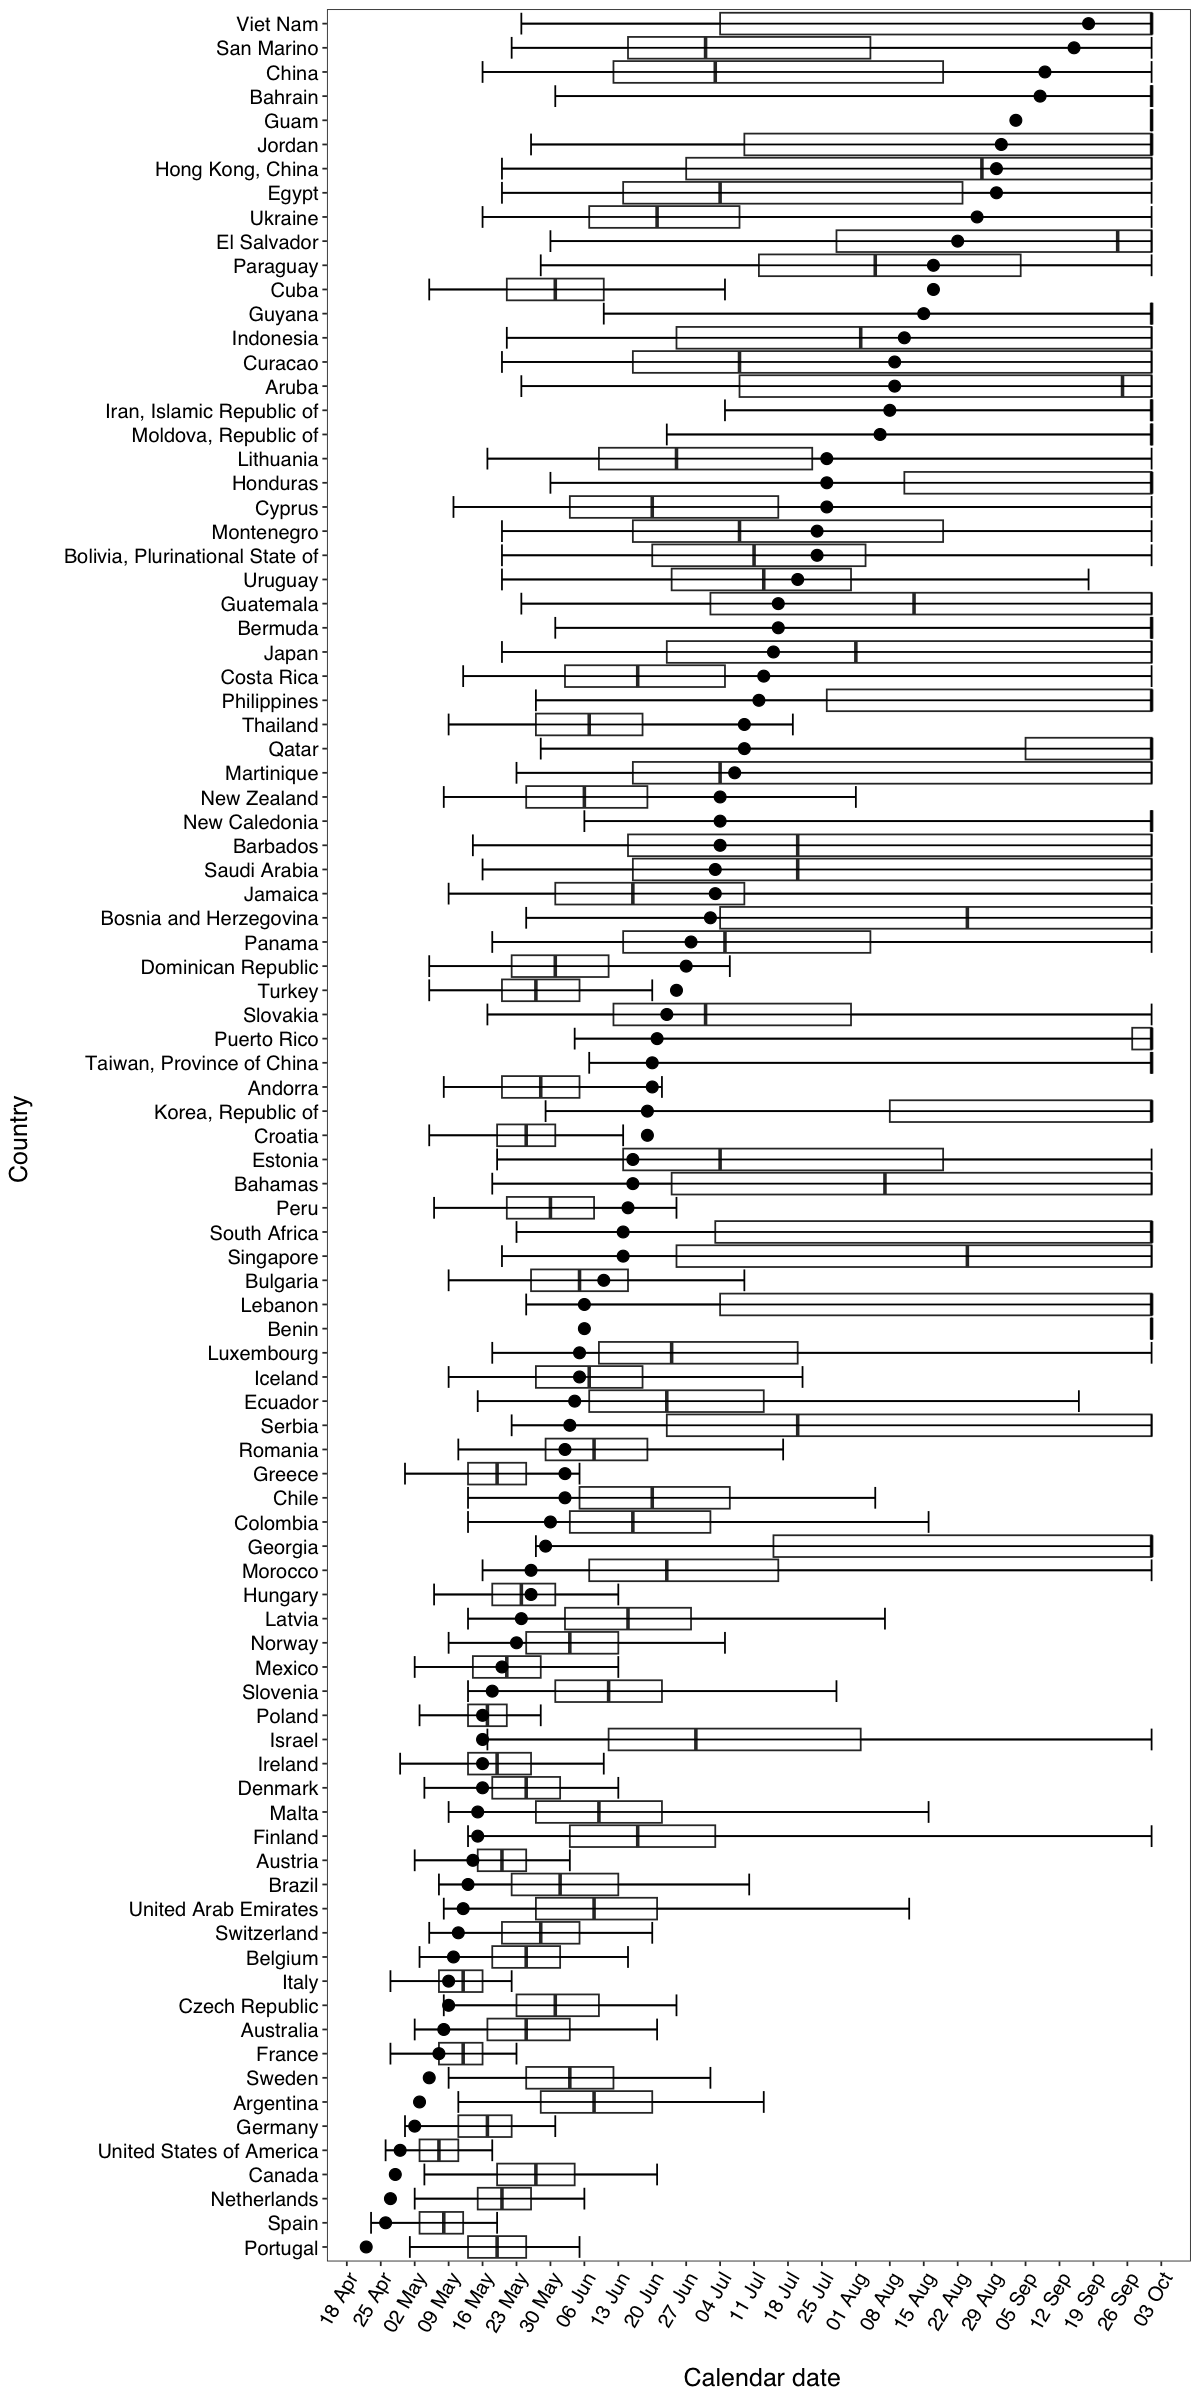

In [37]:
## fitting result
options(repr.plot.width=10,repr.plot.height=20)

# result_quan_list0 %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
# dplyr::select(country, date_imp) %>% distinct() -> quan_imp_list0

Survf_region_fig %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
dplyr::select(country, date_imp) %>% distinct() %>% arrange(date_imp) -> quan_imp_list0

quan_list_all %>% arrange(date_imp_num) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
ggplot() +
geom_boxplot(aes(x = reorder(country,date_imp_num), ymin = q025, lower = q25, middle = q5, upper = q75, ymax = q975), 
             stat = "identity") +
geom_errorbar(aes(x = reorder(country,date_imp_num), ymin = q025, ymax = q975)) +
geom_point(data=quan_imp_list0 %>%
           filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                   "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))), 
           aes(x=reorder(country,date_imp), y=date_imp), size=3) +
labs(x="Country \n", y="\n Calendar date") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      plot.title = element_text(size=18, family="sans",color="black"),
      axis.text.x=element_text(angle=60, hjust=1)) +
scale_y_date(date_labels = "%d %b", date_breaks = "1 weeks") +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on")

ggsave("fitting_regional_WHO.png", width = 10, height = 20)

In [38]:
quan_list_all %>% filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
mutate(date_imp=date_imp_num+start_date-1) %>% 
mutate(count_50=case_when(date_imp <= q25 & date_imp >= q75 ~ 1, TRUE ~ 0),
       count_95=case_when(date_imp <= q025 & date_imp >= q975 ~ 1, TRUE ~ 0)) -> counts

sum(counts$count_50)/nrow(counts); sum(counts$count_50)
sum(counts$count_95)/nrow(counts); sum(counts$count_95)
nrow(counts)

[1] 0.311828

[1] 29

[1] 0.8817204

[1] 82

[1] 93

In [ ]:
# 1. Checking initial case information: Sungmok
# Portugal / UK / Spain
# Moritz --> initial cases

# 2. Different region criteria --> fitting result & estimated k: Sungmok

# 3. Presentation way
# rank-based?

# 4. Differnet alpha in Weibull distribution: Hiro
# degree distribution --> check the fitting again

# 5. Contact flight data (IATA and Etc.)): Fumi

In [ ]:
options(repr.plot.width=8,repr.plot.height=8)
Survf_all_fig %>% filter(country==c("Egypt")) %>%
ggplot() +
geom_line(aes(x=day, y=value, group=country, colour=country), size=1) +
# geom_point(aes(x=day, y=date_imp_num, group=country, colour=country), size=1) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
#       legend.title = element_text(size = 13),
#       legend.text = element_text(size = 13),
      plot.title = element_text(size=18, family="sans",color="black"),
      axis.text.x=element_text(angle=60, hjust=1)) +
scale_y_continuous(expand = c(0, 0))